# MCMC Parameter Estimation for ΛCDM (with Curvature) using DESI Data

This notebook generalizes the Flat ΛCDM MCMC analysis to allow for spatial curvature, i.e., fits for $H_0 \times r_d$, $\Omega_m$, and $\Omega_\Lambda$ (with $\Omega_k = 1 - \Omega_m - \Omega_\Lambda$).

- **Model:** ΛCDM (curved)
- **Data:** DESI BAO measurements
- **Method:**
  - Uses the [`CosmologicalDistances`](../../pyACC/cosmology/distances.py) class from the `pyACC` library
  - Uses the [`LambdaCDM`](../../pyACC/cosmology/cosmology.py) class from the `pyACC` library
  - Uses the `emcee` library to perform Markov Chain Monte Carlo sampling of the posterior distribution for the parameters $H_0 \times r_d$, $\Omega_m$, and $\Omega_\Lambda$.

> **Note:** With DESI data alone, only the product $H_0 \cdot r_d$ can be constrained, not $H_0$ and $r_d$ separately.

In [ ]:
import sys
sys.path.append('/home/giorgio/Documents/Scuola/Università/Università_di_Genova/IV_ANNO/II_Semestre/Astrofisica Computazionale/ESAME/ToloAstroCosmoLib')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyACC.cosmology.cosmology import LambdaCDM
from pyACC.cosmology.distances import CosmologicalDistances

# I load DESI data
file_data = "data.csv"
data = pd.read_csv(file_data)
data = data.astype(float)

z = data["z_eff"].values
D_V_obs = data["D_V / r_d"].values
D_V_err = data["D_V / r_d_err"].values

## Parameterization: $H_0 \times r_d$, $\Omega_m$, $\Omega_\Lambda$ (with $\Omega_k = 1 - \Omega_m - \Omega_\Lambda$)

I sample over $H_0 \times r_d$, $\Omega_m$, and $\Omega_\Lambda$. The curvature parameter is derived as $\Omega_k = 1 - \Omega_m - \Omega_\Lambda$.

In [ ]:
# I define the log-likelihood function for the new parameterization
def log_likelihood(params):
    H0_times_rd, Omega_m, Omega_Lambda = params
    r_d_fixed = 147.05  # Mpc, as specified in the notebook introduction
    # Reasonable bounds for all parameters
    if not (8000 < H0_times_rd < 13000 and 0 < Omega_m < 1 and 0 < Omega_Lambda < 1): #very conservative bounds
        return -np.inf
    H0 = H0_times_rd / r_d_fixed
    model = LambdaCDM(H0, Omega_m, Omega_Lambda, Omega_radiation=0)
    distances = CosmologicalDistances(model.H)
    D_V_model = np.array([distances.volume_distance(z_i) for z_i in z])
    # The model prediction for D_V / r_d is D_V_model / r_d_fixed
    return -0.5 * np.sum(((D_V_obs - D_V_model / r_d_fixed) / D_V_err) ** 2)

## Runnig the MCMC Sampler

I use the `emcee` library (_Goodman & Weare_) to sample the posterior for $H_0 \times r_d$, $\Omega_m$, and $\Omega_\Lambda$.

In [30]:
import emcee

r_d_fixed = 147.05  # Mpc, as specified in the notebook introduction

ndim = 3        # H0_times_rd, Omega_m, Omega_Lambda
nwalkers = 5 * ndim
nsteps = 500000

# Initial guess and spread for walkers
initial = np.array([62.0 * r_d_fixed, 0.5, 0.5])  # H0_times_rd, Omega_m, Omega_Lambda
positions = initial + 1e-2 * np.random.randn(nwalkers, ndim) /2 # Small spread around the initial guess beacuse I'm always unlucky with the initial guess and they fell out of bounds

# Run the MCMCs
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood)
sampler.run_mcmc(positions, nsteps, progress=True)

100%|██████████| 500000/500000 [3:04:29<00:00, 45.17it/s]      


State([[1.00846974e+04 2.50121013e-01 6.21119328e-01]
 [9.94466144e+03 2.83806906e-01 6.45468060e-01]
 [1.00774570e+04 2.67236003e-01 6.46794948e-01]
 [9.47641062e+03 2.27072530e-01 4.07805487e-01]
 [9.88027731e+03 1.95766963e-01 4.92043947e-01]
 [1.00077508e+04 2.93531336e-01 6.59311020e-01]
 [1.01564844e+04 2.94834794e-01 6.89243858e-01]
 [9.54878610e+03 1.69252868e-01 3.42743102e-01]
 [9.88273874e+03 2.71325721e-01 5.95505452e-01]
 [1.03989859e+04 2.95819770e-01 7.70308535e-01]
 [1.00898369e+04 2.51858817e-01 6.36505143e-01]
 [9.93903053e+03 2.31433531e-01 5.44125259e-01]
 [9.93448326e+03 2.52296317e-01 5.88605023e-01]
 [1.00924355e+04 3.04868956e-01 6.87056350e-01]
 [1.01090747e+04 2.92037841e-01 6.86027363e-01]], log_prob=[-2.70125357 -5.90641924 -2.22295794 -6.82591579 -4.71440259 -2.5227385
 -3.05124486 -6.27669702 -2.65722994 -4.4393022  -3.2613578  -3.77903022
 -2.42426376 -2.7329396  -2.26491898], blobs=None, random_state=('MT19937', array([ 194846982,  186482936, 3475285004,

## Plot the evolution of the MCMC in parameter space

This plot shows the trajectory of each walker in the ($H_0 \times r_d$, $\Omega_m$) parameter space as the MCMC evolves.

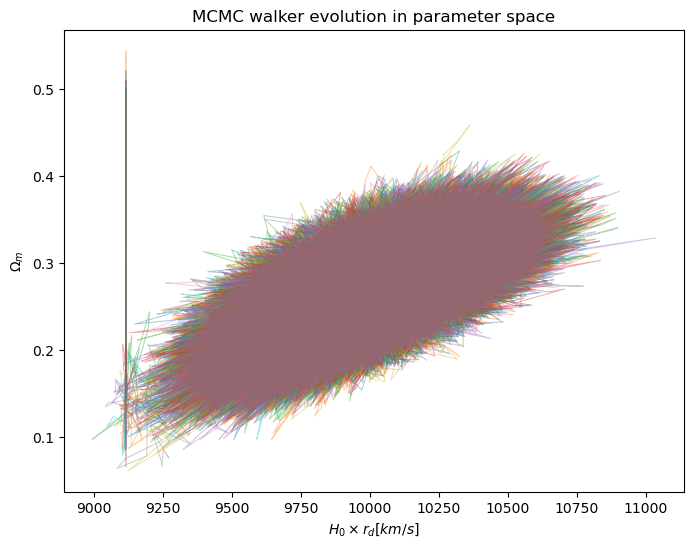

In [31]:
# Plot the evolution of each walker in (H0_times_rd, Omega_m) parameter space
chain = sampler.get_chain()  # shape: (nsteps, nwalkers, ndim)

fig, ax = plt.subplots(figsize=(8, 6))
for j in range(chain.shape[1]):  # for each walker
    ax.plot(chain[:, j, 0], chain[:, j, 1], alpha=0.4, lw=0.7)
ax.set_xlabel(r"$H_0 \times r_d [km/s]$")
ax.set_ylabel(r"$\Omega_m$")
ax.set_title("MCMC walker evolution in parameter space")
plt.show()

<>:26: SyntaxWarning: invalid escape sequence '\O'
<>:26: SyntaxWarning: invalid escape sequence '\O'
/tmp/ipykernel_464005/3078550227.py:26: SyntaxWarning: invalid escape sequence '\O'
  print(f"$\Omega_k$ = {median:.4f} (+{err_plus:.4f}, -{err_minus:.4f})")


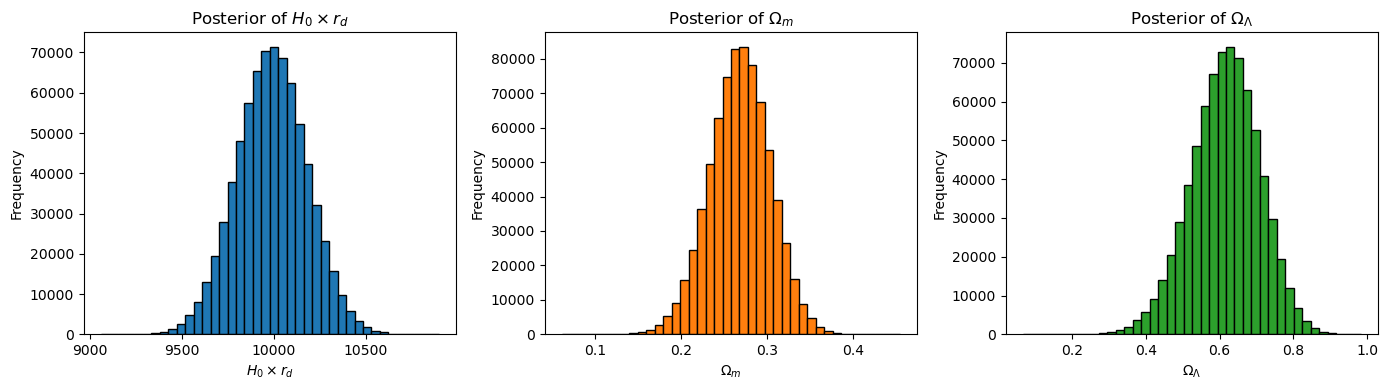

$H_0 \times r_d$: 9989.2329 (+189.5716, -191.1256)
$\Omega_m$: 0.2684 (+0.0343, -0.0353)
$\Omega_\Lambda$: 0.6178 (+0.0888, -0.0951)
$\Omega_k$ = 0.1137 (+0.1272, -0.1200)


In [ ]:
# Analyze and plot the results with matplotlib
samples = sampler.get_chain(discard=1500, thin=10, flat=True)

labels = [r"$H_0 \times r_d$", r"$\Omega_m$", r"$\Omega_\Lambda$"]
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for i in range(3):
    axes[i].hist(samples[:, i], bins=40, color='C'+str(i), edgecolor='k')
    axes[i].set_xlabel(labels[i])
    axes[i].set_ylabel("Frequency")
    axes[i].set_title(f"Posterior of {labels[i]}")

plt.tight_layout()
plt.show()

# Print mean and standard deviation for each parameter
for i, label in enumerate(labels):
    median, lower, upper = np.percentile(samples[:, i], [50, 16, 84])
    print(f"{label}: {median:.4f} (+{upper-median:.4f}, -{median-lower:.4f})")

# I calculate Omega_k and its error and print it since DESI people report that
Omega_k_samples = 1 - samples[:, 1] - samples[:, 2]
median, lower, upper = np.percentile(Omega_k_samples, [50, 16, 84])
err_plus = upper - median
err_minus = median - lower
print(f"$\Omega_k$ = {median:.4f} (+{err_plus:.4f}, -{err_minus:.4f})")

## Plot of Posterior Distributions

Let's visualize the joint and marginal posterior distributions for all parameters using the `corner` library.

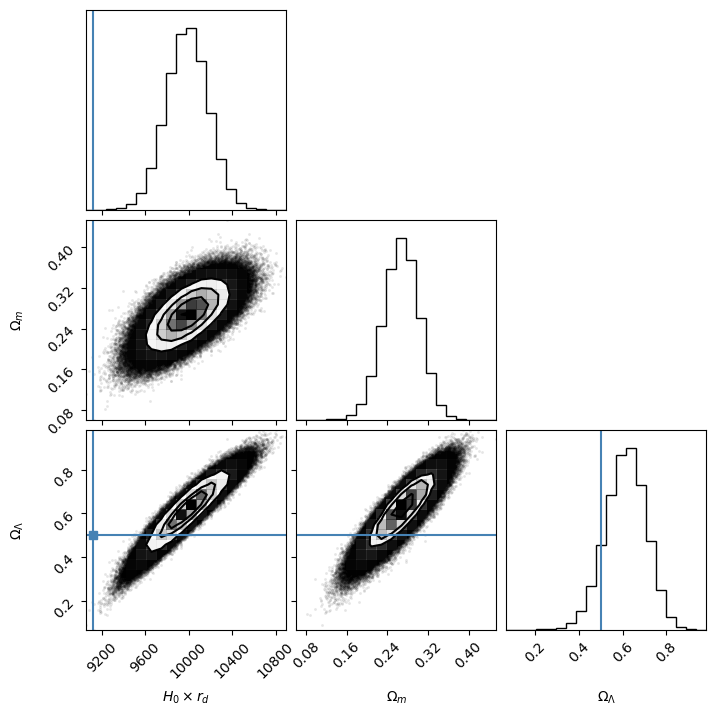

In [33]:
import corner

labels = [r"$H_0 \times r_d$", r"$\Omega_m$", r"$\Omega_\Lambda$"]
fig = corner.corner(samples, labels=labels, truths=initial)

## Comparison with Literature: arXiv:2411.12020v1

<div style="background: #f6f8fa; border-left: 4px solid #0366d6; padding: 1em 1.5em; margin-bottom: 1em;">
<b>Paper Reference:</b> <a href="https://arxiv.org/abs/2411.12020v1" target="_blank">arXiv:2411.12020v1</a>  
<b>Table V, ΛCDM, DESI-only fit</b>
</div>

| ΛCDM              | My $χ^2$ minimization         | My MCMC sample    | Paper |
|-------------------|-------------------------------|-------------------|----------------------------|
| $H_0 \cdot r_d$   | $\text{10003.75} \pm \text{52.95}\,\text{km/s}$   | $9988.5347_{+191.0728}^{-190.0956}\,\text{km/s}$ | ~$\,11000 \,\text{km/s}$           |
| $\Omega_m$        | $\text{0.2696} \pm \text{0.0753}$           | $0.2684_{+0.0344}^{-0.0354}$       | $0.293 \pm 0.012$|
| $\Omega_k$        | $\text{0.1069} \pm \text{0.1748}$           | $0.1137_{+0.1270}^{-0.1201}$       | $0.26 \pm 0.41$ |
